<a href="https://colab.research.google.com/github/getitmoon/supersentiment/blob/main/%5Bchar-level%5DEmotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/Sentiment_classification/

/content/drive/MyDrive/Colab Notebooks/Sentiment_classification


### **Dataset**

In [ ]:
def make_one_hot(labels, num):
  one_hot = []
  for i in range(num):
    one_hot.append(0)
  for idx in labels:
    one_hot[idx] = 1
  return one_hot

### **Dataset1 : Emotions**

In [ ]:
# train dataset
tokenized_train_dataset = []

# validation dataset
tokenized_validation_dataset = []

# test dataset/
tokenized_test_dataset = []

In [ ]:
dataset_list = [("./dataset/Emotions/original_dataset/train.csv", 1, 2, tokenized_train_dataset, 6),
                ("./dataset/Emotions/original_dataset/dev.csv", 1, 2, tokenized_validation_dataset, 6),
                ("./dataset/Emotions/original_dataset/test.csv", 1, 2, tokenized_test_dataset, 6)]

### **Dataset2: GoEmotions**

In [ ]:
# dataset_list = [("./dataset/GoEmotions/train.tsv", 0, 1, tokenized_train_dataset, 28),
#                 ("./dataset/GoEmotions/dev.tsv", 0, 1, tokenized_validation_dataset, 28),
#                 ("./dataset/GoEmotions/test.tsv", 0, 1, tokenized_test_dataset, 28)]

In [ ]:
def build_charset(paths):
  charset = set()
  for path in paths:
    rawData = open(path[0]).read().split('\n')
    length = len(rawData) - 1
    chars = set()
    delimiter = ","
    if (path[0].endswith('.tsv')):
        delimiter = "\t"
    for i in range(length):
      chars = chars | set(rawData[i].split(delimiter)[path[1]])
    charset = charset | chars
  return charset

charset = build_charset(dataset_list)

In [ ]:
print(charset)

{'e', 'p', 'v', 's', 'b', 'w', 'y', 'n', 'i', 'l', 'm', 'h', 'd', 'z', 'f', 'a', 'c', 'x', 'u', 'k', 'o', 'g', ' ', 'q', 'j', 'r', 't'}


In [ ]:
print(len(charset))

27


In [ ]:
# print(f"charset2: {len(charset2)}")

In [ ]:
# print(charset2)

### **Emotions experiment**

In [ ]:
char_stoi = {'<pad>':0}
char_itos = {0:'<pad>'}
for i, char in enumerate(charset):
  char_stoi[char] = i+1
  char_itos[i+1] = char

In [ ]:
class dataset:
  def __init__(self, src, trg):
    self.src = src
    self.trg = trg

In [ ]:
from tqdm import tqdm

In [ ]:
def tokenize(paths):
  global char_stoi
  for path in paths:
    rawData = open(path[0]).read().split('\n')
    length = len(rawData) - 1
    if path[0].endswith("train.csv"):
      length = 40000
    elif path[0].endswith("dev.csv"):
      length = 5000
    elif path[0].endswith("test.csv"):
      length = 5000
    delimiter = ","
    if (path[0].endswith('.tsv')):
        delimiter = "\t"
    for i in tqdm(range(length)):
      line = rawData[i].split(delimiter)
      chars = [char_stoi[c] for c in line[path[1]]] # path[1] is sentence index
      if (len(chars) > 36):
        chars = chars[:36]
      diff = 36 - len(chars)
      for i in range(diff):
        chars.append(0)
      label = [int(l) for l in line[path[2]].split(",")]
      path[3].append(dataset(chars, make_one_hot(label, path[4])))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
tokenize(dataset_list)

100%|██████████| 5000/5000 [00:00<00:00, 108132.95it/s]


In [ ]:
tokenized_train_dataset[0].src

[9,
 23,
 25,
 19,
 4,
 27,
 23,
 15,
 1,
 1,
 10,
 23,
 26,
 1,
 16,
 10,
 10,
 7,
 23,
 12,
 1,
 10,
 2,
 10,
 1,
 4,
 4,
 23,
 16,
 8,
 13,
 23,
 12,
 1,
 16,
 3]

In [ ]:
BATCH_SIZE = 128

def batch(dt):
  batched = []
  one_batch_s = []
  one_batch_t = []
  i = 0
  for data in dt:
    s = data.src
    t = data.trg
    i += 1
    one_batch_s.append(s)
    one_batch_t.append(t)
    if (i == BATCH_SIZE): # append batch and initialize
      batched.append(dataset(torch.tensor(one_batch_s).to(device), torch.tensor(one_batch_t).to(device)))
      one_batch_s = []
      one_batch_t = []
      i = 0
  if i != BATCH_SIZE:
    batched.append(dataset(torch.tensor(one_batch_s).to(device), torch.tensor(one_batch_t).to(device)))
  return batched

In [ ]:
# batched train dataset
train_dataset = batch(tokenized_train_dataset)

# batched validation dataset
validation_dataset = batch(tokenized_validation_dataset)

# batched test dataset
test_dataset = batch(tokenized_test_dataset)

In [ ]:
train_dataset[0].src

tensor([[ 9, 23, 25,  ...,  1, 16,  3],
        [ 9,  3,  1,  ..., 16,  5, 21],
        [ 9, 23, 22,  ..., 13, 11, 26],
        ...,
        [ 9, 11, 23,  ..., 23, 27, 12],
        [ 9, 23,  8,  ...,  3,  1,  8],
        [ 9, 23, 15,  ...,  4, 27, 23]], device='cuda:0')

### **Build Model**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 36): # 36 보다 작게 하면 cuda 에러 남
        super().__init__()

        ''' Input Embedding '''
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        ''' Multiple Encoder Layers '''
        # we use multiple encoder layers (e.g., 6 in the original Transformer paper)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = nn.Parameter(torch.sqrt(torch.FloatTensor([hid_dim])))
        self.device = device

    def forward(self, src):
        seq_length = src.size(1) # with batch src.size(1)
        # positional embedding dimension: S x H
        embedded_pos = self.pos_embedding(torch.arange(seq_length, device=self.device))
        # token embedding, dimension: S x H
        embedded_tok = self.tok_embedding(src)
        # two embeddings added, dimension: S x H; positional embedding broadcasted
        embedded = torch.add(embedded_tok, embedded_pos)

        output = embedded
        for layer in self.layers:
          output = layer(output, None)
          output = self.dropout(output)

        return output

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout):
        super().__init__()

        ''' Multi Head self-Attention '''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positional FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # multihead attention
        # dimension: S x H
        x_a, _ = self.self_attention(src, src, src, src_mask)
        x_a = self.self_attn_layer_norm(self.dropout(x_a) + src)
        # positionwise feed forward
        x_f = self.positionwise_feedforward(x_a)
        src = self.ff_layer_norm(self.dropout(x_f) + x_a)

        return src

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        # TODO: write your code
        # assumption: hid_dim is a multiple of n_heads
        self.n_heads = n_heads

        self.weight_query = nn.Linear(hid_dim, hid_dim)
        self.weight_key = nn.Linear(hid_dim, hid_dim)
        self.weight_value = nn.Linear(hid_dim, hid_dim)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask = None):

        # TODO: write your code
        # dimension: B x S(1/2/3) x n_heads x H/n_heads
        Q = self.weight_query(query).view(query.size(0), query.size(1), self.n_heads, -1)
        K = self.weight_key(key).view(key.size(0), key.size(1), self.n_heads, -1)
        V = self.weight_value(value).view(value.size(0), value.size(1), self.n_heads, -1)

        # dimension: B x n_heads x S x H/n_heads
        Q, K, V = torch.transpose(Q, 1, 2), torch.transpose(K, 1, 2), torch.transpose(V, 1, 2)
        # dimension: B x n_heads x S1(query sentence length) x S2(key sentence length)
        dot = torch.matmul(Q, torch.transpose(K, 2, 3))
        scaled_dot = torch.div(dot, self.scale)
        if mask is not None:
          scaled_dot = scaled_dot.masked_fill(mask, -1e19) # -math.inf

        # attention dimension: B x n_heads x S1 x S2
        attention = nn.functional.softmax(scaled_dot, dim=3)

        attention = self.dropout(attention)
        # dimension: B x n_heads x S1 x H/n_heads
        weighted_sum = torch.matmul(attention, V) # V dimension: B x n_heads x S x H/n_heads
        # concat multiheads
        x = torch.cat([weighted_sum[:, i, :, :] for i in range(self.n_heads)], dim=-1)

        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        # TODO: write your code
        self.linear1 = nn.Linear(hid_dim, pf_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        # TODO: write your code
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x

In [ ]:
class Classification(nn.Module):
    def __init__(self,
                 encoder,
                 hid_dim,
                 out_dim,
                 device):
        super().__init__()
        self.encoder = encoder
        self.linear = nn.Linear(hid_dim, out_dim) # can add more!!!
        self.device = device


    def forward(self, src, trg=None):

        ## TODO: write down the forward step
        # encoder output dimension: B x S_en x H
        en_output = self.encoder(src)
        en_output = torch.sum(en_output, 1) # B x H
        # B x O
        output = self.linear(en_output)

        return output

In [ ]:
INPUT_DIM = len(char_stoi)
# WINPUT_DIM = 256
# WEN_LAYERS = 4
# INPUT_DIM = WINPUT_DIM * WEN_LAYERS
OUTPUT_DIM = 6
HID_DIM = 256
ENC_LAYERS = 3 #2
ENC_HEADS = 4
ENC_PF_DIM = 256
ENC_DROPOUT = 0.1

# wenc = wordEncoder(len(char_stoi), WINPUT_DIM)
enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)

In [ ]:
model = Classification(enc, HID_DIM, OUTPUT_DIM, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,007,879 trainable parameters


In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE) # Adam, try SGD

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here
        output = model(src)
        # loss
        loss = criterion(output, trg.float())

        # perform a backwared pass, and update the weights
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here
            output = model(src)
            # loss
            loss = criterion(output, trg.float())

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataset, optimizer, criterion)
    valid_loss = evaluate(model, validation_dataset, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 3s
	Train Loss: 0.382
	 Val. Loss: 0.389
Epoch: 02 | Time: 0m 3s
	Train Loss: 0.377
	 Val. Loss: 0.387
Epoch: 03 | Time: 0m 3s
	Train Loss: 0.372
	 Val. Loss: 0.384
Epoch: 04 | Time: 0m 3s
	Train Loss: 0.368
	 Val. Loss: 0.381
Epoch: 05 | Time: 0m 3s
	Train Loss: 0.364
	 Val. Loss: 0.385
Epoch: 06 | Time: 0m 3s
	Train Loss: 0.361
	 Val. Loss: 0.384
Epoch: 07 | Time: 0m 3s
	Train Loss: 0.359
	 Val. Loss: 0.380
Epoch: 08 | Time: 0m 3s
	Train Loss: 0.355
	 Val. Loss: 0.379
Epoch: 09 | Time: 0m 3s
	Train Loss: 0.353
	 Val. Loss: 0.382
Epoch: 10 | Time: 0m 3s
	Train Loss: 0.349
	 Val. Loss: 0.376
Epoch: 11 | Time: 0m 3s
	Train Loss: 0.345
	 Val. Loss: 0.382
Epoch: 12 | Time: 0m 3s
	Train Loss: 0.341
	 Val. Loss: 0.379
Epoch: 13 | Time: 0m 3s
	Train Loss: 0.339
	 Val. Loss: 0.385
Epoch: 14 | Time: 0m 3s
	Train Loss: 0.338
	 Val. Loss: 0.380
Epoch: 15 | Time: 0m 3s
	Train Loss: 0.336
	 Val. Loss: 0.379
Epoch: 16 | Time: 0m 3s
	Train Loss: 0.333
	 Val. Loss: 0.379
Epoch: 1

In [ ]:
model.load_state_dict(torch.load('my-model.pt'))

test_loss = evaluate(model, test_dataset, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 0.370


In [ ]:
w = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
TP = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
TN = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
FP = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
FN = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
def assign_f1 (pred_, label_):
  for pred, label in zip(pred_, label_): # for each batch
    for i in range(len(pred)):
      if label[i] == 1: # count true instances
        w[i] += 1
      if pred[i] == 1 and pred[i] == label[i]: # TP
        TP[i] += 1
      elif pred[i] == 1 and pred[i] != label[i]: # FP
        FP[i] += 1
      elif pred[i] == 0 and pred[i] == label[i]: # TN
        TN[i] += 1
      else: # FN
        FN[i] += 1

def get_f1_score (is_weighted):
  precision = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  recall = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  F1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  for i in range(len(TP)):
    if (TP[i] != 0):
      precision[i] = TP[i] / (TP[i] + FP[i])
      recall[i] = TP[i] / (TP[i] + FN[i])
      F1[i] = 2*precision[i]*recall[i] / (precision[i] + recall[i])
  tot_precision = 0
  tot_recall = 0
  tot_f1_score = 0
  if (is_weighted):
    s = sum(w)
    for i in range(len(w)):
      weight = w[i]/s
      tot_precision += weight * precision[i]
      tot_recall += weight * recall[i]
      tot_f1_score += weight * F1[i]
  else:
    l = 6
    tot_precision = sum(precision) / l
    tot_recall = sum(recall) / l
    tot_f1_score = sum(F1) / l
  return tot_precision, tot_recall, tot_f1_score

In [ ]:
def evaluate_f1(iterator, model, threshold=0.5, is_weighted=True):
    model.eval()

    with torch.no_grad():
        check = 0
        for batch in iterator:
            src = batch.src
            trg = batch.trg

            output = model(src)
            output = torch.sigmoid(output)
            predicted = (output > threshold).int()

            labels = trg.int()
            assign_f1(predicted.tolist(), labels.tolist())

    precision, recall, f1 = get_f1_score(is_weighted) # weighted

    return precision, recall, f1

boolean = True
precision, recall, f1 = evaluate_f1(test_dataset, model, 0.5, boolean)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.6383
Recall: 0.2380
F1 Score: 0.3299


In [ ]:
precision, recall, f1 = evaluate_f1(test_dataset, model, 0.2)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.4140
Recall: 0.4384
F1 Score: 0.4044


In [ ]:
precision, recall, f1 = evaluate_f1(test_dataset, model, 0.1)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.3287
Recall: 0.5654
F1 Score: 0.4123


In [ ]:
print(w)

[4389, 5031, 1302, 1941, 1833, 504, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
sentiment = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
def classify_sentence(sentence, model, device, max_len = 50):

    model.eval()

    chars = [char_stoi[c] for c in sentence] # path[1] is sentence index
    if len(chars) > 36:
      chars = chars[:36]
    diff = 36 - len(chars)
    for i in range(diff):
      chars.append(0)
    src = torch.tensor([chars], device=device)
    sentiment = model(src)

    return sentiment

In [ ]:
def display_sentiment(sentence):
    global sentiment, model, device
    res = classify_sentence(sentence, model, device)
    res = nn.functional.softmax(res, -1).squeeze().tolist()
    res = [int(1000*d)/1000 for d in res]

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(sentiment, res)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
    plt.show()
    plt.close()

<ipython-input-68-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


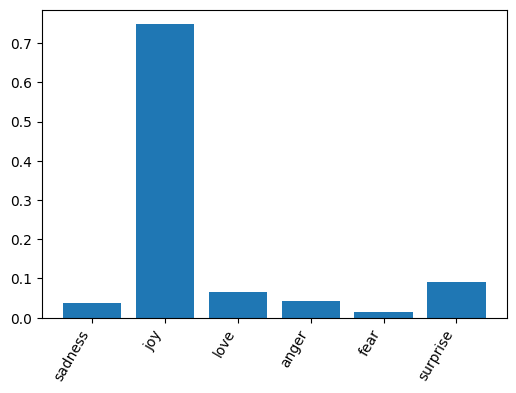

In [ ]:
display_sentiment("i hope i can do well")

<ipython-input-68-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


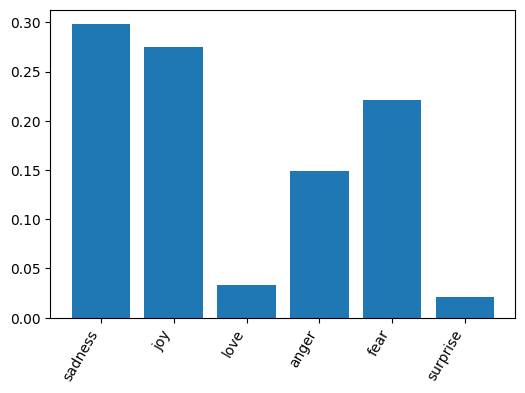

In [ ]:
display_sentiment("i am sure that i can do it")

<ipython-input-68-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


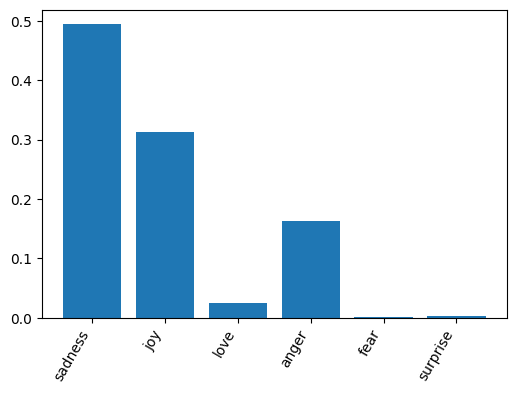

In [ ]:
display_sentiment("i love myself")

<ipython-input-68-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


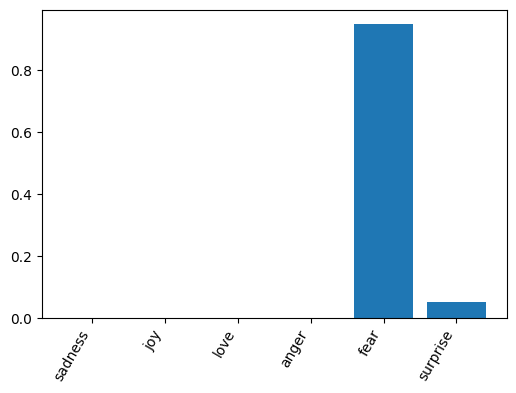

In [ ]:
display_sentiment("this is fun")

<ipython-input-68-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


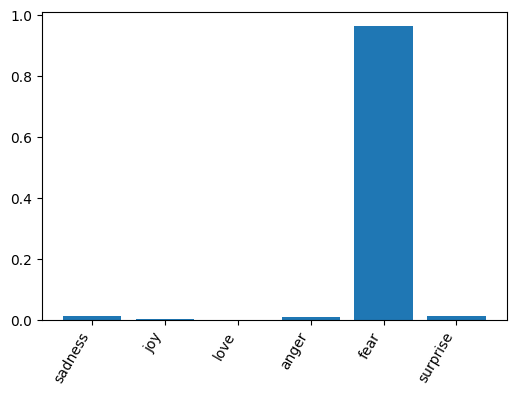

In [ ]:
display_sentiment("this is not fun")

<ipython-input-68-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


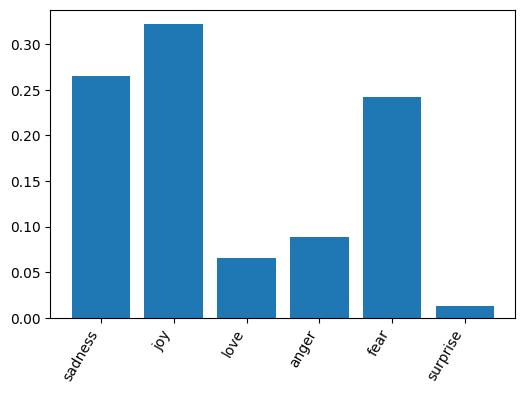

In [ ]:
display_sentiment("i don t want to have a bad dream anymore")

<ipython-input-68-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


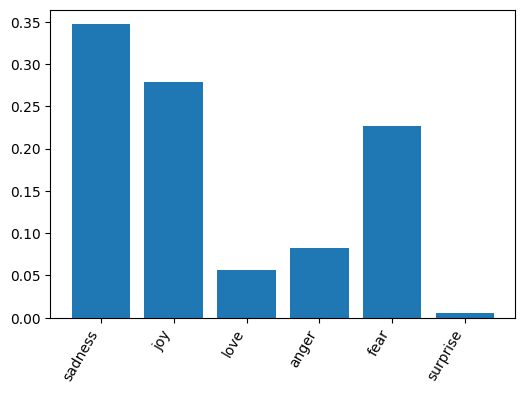

In [ ]:
display_sentiment("i don t want to have a bad dream")

<ipython-input-68-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


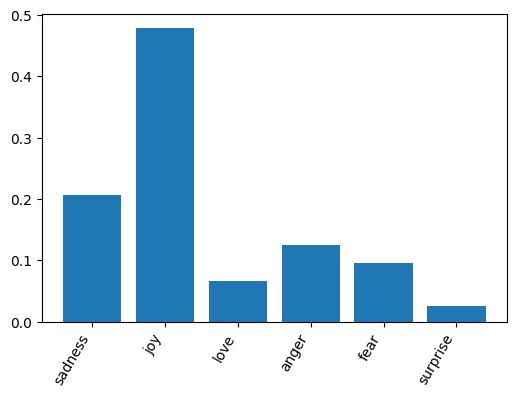

In [ ]:
display_sentiment("her heart swelled with joy as she watched the sunset its vibrant colors painting the sky in a breathtaking display")

<ipython-input-68-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


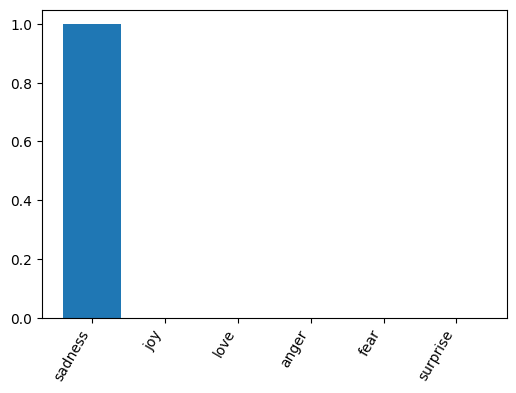

In [ ]:
display_sentiment("happy")

<ipython-input-68-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


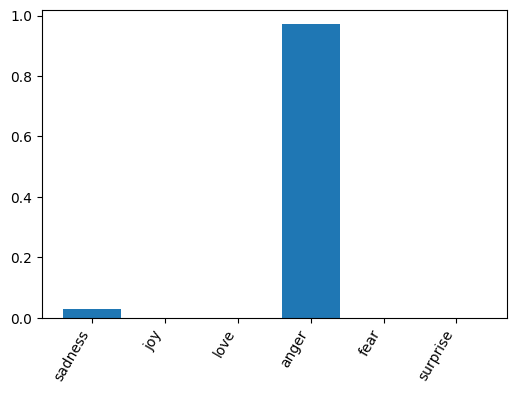

In [ ]:
display_sentiment("not happy")

In [ ]:
display_sentiment("Very very nice to see this irl. Nice post")

KeyError: 'V'

In [ ]:
display_sentiment("OMG! I need to make these. This looks so good!")

In [ ]:
display_sentiment("thank you for helping me")

In [ ]:
display_sentiment("i should have finished earlier")

In [ ]:
def display(data):
    global sentiment, model, device
    res = data
    res = [int(1000*d)/1000 for d in res]

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(sentiment, res)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
    plt.show()
    plt.close()
display(w)